# Install Packages

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from datetime import datetime
import io
import os
import pymongo
from six import string_types

# Text Extraction

## Confirm Import

In [3]:
conn=pymongo.MongoClient('mongodb', 27017)

# Check database names to test connection and see what's here
conn.database_names()

['admin', 'iati', 'local']

In [4]:
# Make iati database
db = conn.iati

# Create new activities collection and check that manual renaming worked

activities=db.activities
metadata=db.metadata

db.collection_names()

['cleaned_orgs_full',
 'quality',
 'transactions',
 'organizations_metadata',
 'organizations',
 'activities',
 'scores',
 'activities_metadata']

In [5]:
def get_en(x):
    if type(x) is list:
        for y in x:
            if isinstance(y,string_types):
                return y
            if y.get('@xml:lang'=='en'):
                return y
        return x[0]
    return x
def get_text(x):
    x=get_en(x)
    if x is not None:
        if isinstance(x, string_types):
            return x
        txt=x.get('#text')
        if isinstance(txt, string_types):
            return txt
        n=get_en(x.get('narrative'))
        if n is not None:
            if isinstance(n, string_types):
                return n
            return n.get('#text')
orgs=[]
for x in db.organizations.find(projection={'name': True, 'reporting-org': True,  '_id': False}):
    if 'reporting-org' not in x:
        continue
    name=get_text(x.get('name'))
    org=get_en(x['reporting-org'])
    if '@ref' not in org:
        continue

    if name is None:
        name=get_text(org)
    if name is None:
        name="[unknown]"
    orgs.append((org['@ref'], name))
orgs[:10]

[('NL-KVK-41210098', 'Both ENDS'),
 ('MW-NBM-00139', 'Theatre for a Change Malawi'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF'),
 ('41122', 'UNICEF')]

In [6]:
id2org=dict(orgs)
org2id={y:x for x,y in orgs}

In [7]:
from collections import Counter, defaultdict
collabs=defaultdict(Counter)
columns={'name': True, 'reporting-org': True, 'participating-org': True, '_id': False}

for x in db.activities.find(projection=columns):
    repOrg=get_en(x['reporting-org'])
    repId=None
    if not isinstance(repOrg, string_types):
        repId=repOrg.get('@ref')
    if not repId:
        name=get_text(repOrg)
        repId=org2id.get(name)
        if not repId:
            #print("Reporting org not found: ", name)
            continue

    collabIds=[]
    partOrgs=x.get('participating-org',[])
    if isinstance(partOrgs, string_types):
        partOrgs={'@ref': partOrgs}
    if not isinstance(partOrgs, list):
        partOrgs=[partOrgs]
    for y in partOrgs:
        ref=None
        if not isinstance(y, string_types):
            ref=y.get('@ref')
        if not ref:
            name=get_text(y)
            ref=org2id.get(name)
            if not ref:
                #print("Participating org not found: ", name)
                continue
        if ref!=repId:
            collabIds.append(ref)
    if collabIds:
        collabs[repId].update(collabIds)


In [8]:
import pandas as pd
import numpy as np
df=pd.DataFrame(collabs, columns=id2org.keys(), dtype=float)

In [9]:
# missing is 0, not NA
df[df.applymap(np.isnan)]=0

In [10]:
# normalize
zdf=df.as_matrix()

In [11]:
sim=zdf.T.dot(zdf)

In [12]:
pd.DataFrame(sim).describe()

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
count,272.000000,272.000000,272.000000,272.0,272.000000,2.720000e+02,272.0,272.000000,272.000000,272.0,...,272.000000,2.720000e+02,2.720000e+02,272.0,2.720000e+02,2.720000e+02,272.0,272.0,272.000000,272.000000
mean,5.713235,0.003676,10.808824,0.0,1.051471,5.816488e+05,0.0,1.231618,215.209559,0.0,...,12.014706,1.481067e+05,2.545723e+05,0.0,2.401457e+05,2.381166e+05,0.0,0.0,28.110294,2076.849265
std,45.879983,0.060634,90.729354,0.0,3.287727,7.176633e+06,0.0,15.481260,2110.762279,0.0,...,85.048585,2.265051e+06,2.979061e+06,0.0,2.681785e+06,2.452487e+06,0.0,0.0,228.343665,19033.117707
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.0,1.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,...,1.000000,0.000000e+00,0.000000e+00,0.0,4.890000e+02,4.200000e+02,0.0,0.0,0.000000,0.000000
max,489.000000,1.000000,1365.000000,0.0,29.000000,1.162123e+08,0.0,243.000000,28349.000000,0.0,...,978.000000,3.734493e+07,4.546188e+07,0.0,4.327503e+07,3.858469e+07,0.0,0.0,2445.000000,235786.000000


In [13]:
import matplotlib.pyplot as plt

(array([  7.39760000e+04,   5.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0.00000000e+00,   8.01644586e+08,   1.60328917e+09,
          2.40493376e+09,   3.20657834e+09,   4.00822293e+09,
          4.80986751e+09,   5.61151210e+09,   6.41315669e+09,
          7.21480127e+09,   8.01644586e+09]),
 <a list of 10 Patch objects>)

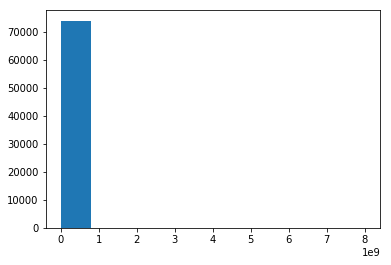

In [14]:
plt.hist(sim.flatten())

In [15]:
from sklearn.decomposition import PCA
fact=PCA(n_components=.999999999)
sim_txf=fact.fit_transform(sim)
((sim-fact.components_[sim_txf.argmax(axis=1)])**2).sum()

1.2912221812983004e+20

### len(orgs), len(set(x[0] for x in orgs)),len(set(x[1] for x in orgs))

In [16]:
pprint(activities.find_one())

Pretty printing has been turned OFF


## Extract Text

In [17]:
%%writefile text_extraction.py

import bson
from feature_creation import find_reporting_org
import re

try:
    unicode = str
except:
    pass

Overwriting text_extraction.py


Text will be extracted as all fields on the `iati-activity` element as will as all fields on the parent `iati-activities` element.

In [18]:
%%writefile -a text_extraction.py

def extract_text(json_object):
    if json_object is None:
        return ''

    text = []

    object_type = type(json_object)

    # Recursively extract the text based on the data structure until we are at
    # the "no data structure here" text leaf node.

    if object_type is dict:
        text = [extract_text(value) for value in json_object.values()]
    elif object_type is list:
        text = [extract_text(value) for value in json_object]
    elif object_type is str or object_type is unicode:
        text = [re.sub(r'\s+', ' ', unicode(json_object)).strip()]
    elif object_type is bson.objectid.ObjectId:
        text = []
    else:
        print(object_type)

    return ' '.join([item for item in text if len(item) > 0])

Appending to text_extraction.py


In [19]:
%%writefile -a text_extraction.py

def is_valid_ref_format(ref):
    if ref is None:
        return False

    if ref.find('-') == -1:
        return False

    if ref.find(' ') != -1:
        return False

    return True

Appending to text_extraction.py


In [20]:
%%writefile -a text_extraction.py

def get_iati_text_line(activity):
    row_id = find_reporting_org(activity['reporting-org'])
   
    if not is_valid_ref_format(row_id):
        return None
   
    return '%s\t%s\n' % (row_id, extract_text(activity))

Appending to text_extraction.py


In [21]:
from text_extraction import get_iati_text_line
from multiprocessing import Pool, cpu_count

In [22]:
pool = Pool(cpu_count())

In [23]:
parse_failures = []
activities_count = activities.count()

print(datetime.now(), 'Started processing')

with io.open('iati_text.txt', 'w', encoding='utf-8') as f:
    joined_activities = activities.aggregate([{
        '$lookup': {
            'from': 'metadata',
            'localField': '@w210-filename',
            'foreignField': '@w210-filename',
            'as': 'metadata'
        }
    }])

    num = 0
   
    for line in pool.imap_unordered(get_iati_text_line, joined_activities):
        if num % 25000 == 0:
            print(datetime.now(), 'Processed', num, 'of', activities_count)
       
        num += 1

        if line is not None:
            f.write(line)

print(datetime.now(), 'Finished processing')

2017-12-31 23:07:00.426547 Started processing
2017-12-31 23:07:00.447685 Processed 0 of 764159
2017-12-31 23:07:06.916065 Processed 25000 of 764159
2017-12-31 23:07:14.060837 Processed 50000 of 764159
2017-12-31 23:07:22.267832 Processed 75000 of 764159
2017-12-31 23:07:29.736179 Processed 100000 of 764159
2017-12-31 23:07:37.797888 Processed 125000 of 764159
2017-12-31 23:07:44.677508 Processed 150000 of 764159
2017-12-31 23:07:51.632685 Processed 175000 of 764159
2017-12-31 23:07:59.679920 Processed 200000 of 764159
2017-12-31 23:08:08.184402 Processed 225000 of 764159
2017-12-31 23:08:15.057667 Processed 250000 of 764159
2017-12-31 23:08:20.280598 Processed 275000 of 764159
2017-12-31 23:08:28.440842 Processed 300000 of 764159
2017-12-31 23:08:35.408095 Processed 325000 of 764159
2017-12-31 23:08:43.217559 Processed 350000 of 764159
2017-12-31 23:08:50.464675 Processed 375000 of 764159
2017-12-31 23:08:56.953008 Processed 400000 of 764159
2017-12-31 23:09:05.215052 Processed 425000 

# Upload to S3

In [24]:
s3_bucket = 'mdang.w210'

In [25]:
!gzip iati_text.txt
!aws s3 cp iati_text.txt.gz s3://{s3_bucket}/ --acl public-read
!gunzip iati_text.txt.gz

upload: ./iati_text.txt.gz to s3://mdang.w210/iati_text.txt.gz
